In [1]:
#!/usr/bin/env python

# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Xinlei Chen, based on code from Ross Girshick
# --------------------------------------------------------

"""
Demo script showing detections in sample images.

See README.md for installation instructions before running.
"""
# %matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

from model.config import cfg
from model.test import im_detect
from torchvision.ops import nms

from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import argparse

# from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1

import torch

import datetime
import requests
import base64
import json

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

In [2]:
NETS = {'vgg16': ('vgg16_faster_rcnn_iter_%d.pth',),'res101': ('res101_faster_rcnn_iter_%d.pth',)}
DATASETS= {'pascal_voc': ('voc_2007_trainval',),'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}

demonet = 'res101' # Network to use [vgg16 res101]
dataset = 'pascal_voc_0712' # Trained dataset [pascal_voc pascal_voc_0712]

def load_module():
    cfg.TEST.HAS_RPN = True  # Use RPN for proposals

    # model path
    saved_model = os.path.join('../output', demonet,
                              NETS[demonet][0] %(70000 if dataset == 'pascal_voc' else 110000))


    if not os.path.isfile(saved_model):
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(saved_model))

    net = resnetv1(num_layers=101)
    net.create_architecture(21, tag='default', anchor_scales=[8, 16, 32])
    net.load_state_dict(torch.load(saved_model, map_location=lambda storage, loc: storage))

    net.eval()
    if not torch.cuda.is_available():
        net._device = 'cpu'
    net.to(net._device)

    return net

In [3]:
def _append_coords(scores, boxes, categories, x_offset=0):
    result = dict()
    for category in categories:
        idx_boxes = boxes[:, 4*category:4*(category + 1)]
        idx_scores = scores[:, category]
        clean_idx = nms(torch.from_numpy(idx_boxes), torch.from_numpy(idx_scores), NMS_THRESH)
        valid_idxs = clean_idx.numpy()[np.where(idx_scores[clean_idx.numpy()] > CONF_THRESH)]
        valid_boxes = idx_boxes[valid_idxs]
        
        result[category] = np.vstack((
            (x_offset + (valid_boxes[:, 0] + valid_boxes[:, 2]) / 2),
            (valid_boxes[:, 1] + valid_boxes[:, 3]) / 2)).T
    return result

In [4]:
def _get_valid_boxes(scores, boxes, category, offset=0):
    idx_boxes = boxes[:, 4*category:4*(category + 1)]
    idx_scores = scores[:, category]
    clean_idx = nms(torch.from_numpy(idx_boxes), torch.from_numpy(idx_scores), NMS_THRESH)
    valid_idxs = clean_idx.numpy()[np.where(idx_scores[clean_idx.numpy()] > CONF_THRESH)]
    valid_boxes = idx_boxes[valid_idxs]
    valid_boxes[:, 0] += offset
    valid_boxes[:, 2] += offset
    return valid_boxes

In [5]:
NMS_THRESH = 0.3
CONF_THRESH = 0.8

def get_boxes(net, file_path, categories):
    im = cv2.imread(file_path)
    
    mid_x = im.shape[1]//2
    
    output = dict()
    
    left_scores, left_boxes = im_detect(net, im[:, :mid_x])
    right_scores, right_boxes = im_detect(net, im[:, mid_x:])
    
    output = dict()
    for category in categories:
        left_valid_boxes = _get_valid_boxes(left_scores, left_boxes, category)
        right_valid_boxes = _get_valid_boxes(right_scores, right_boxes, category, mid_x)
        output[category] = np.concatenate((left_valid_boxes, right_valid_boxes))
        
    return output

In [6]:
def draw_boxes(file_path, boxes):
    if len(boxes) == 0:
        return
    
    im = cv2.imread(file_path)[:, :, (2, 1, 0)]
    
    fig, ax = plt.subplots(figsize=(24, 12))
    ax.imshow(im, aspect='equal')
    fig.subplots_adjust(wspace=0.)
    for class_name, coords, color in zip(boxes.keys(), boxes.values(), ("blue", "blue", "red")):
        for bbox in coords:
            ax.add_patch(plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor=color, linewidth=3.5))
            ax.text(bbox[0], bbox[1] - 2, CLASSES[class_name],
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=14, color='white')

    plt.tight_layout()
    plt.draw()

In [27]:
def draw_points(file_path, boxes):
    if len(boxes) == 0:
        return
    
    im = cv2.imread(file_path)[:, :, (2, 1, 0)]
    
    fig, ax = plt.subplots(figsize=(24, 12))
    ax.imshow(im, aspect='equal')
    fig.subplots_adjust(wspace=0.)
    for coords, color, marker in zip(boxes.values(), ("blue", "blue", "red"), ('d', 'd', 'o')):
        if len(coords) == 0:
            continue
        ax.scatter((coords[:, 0]+coords[:, 2])/2, (coords[:, 1]/4+coords[:, 3]*3/4), marker=marker, s=20*4*5, c=color)

    plt.tight_layout()
    plt.draw()

In [8]:
IMAGE_H = 512
IMAGE_W = 1392

src = np.float32([[0, IMAGE_H*3/7], [IMAGE_W, IMAGE_H*3/7], [IMAGE_W, IMAGE_H], [0, IMAGE_H]])
dst = np.float32([[0, 0], [IMAGE_W, 0], [IMAGE_W-386, IMAGE_H+IMAGE_H/3], [386, IMAGE_H+IMAGE_H/3]])
M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix

def _transform_points(coords):
    coords = np.pad(coords, ((0, 0), (0, 1)), mode="constant", constant_values=1)

    transformed = np.dot(M, coords.T)
    return transformed[:2] / transformed[-1]

In [29]:
def draw_transformed_points(file_path, boxes):
    if len(boxes) == 0:
        return
    
    im = cv2.imread(file_path)[:, :, (2, 1, 0)]
    
    fig, ax = plt.subplots(figsize=(24, 12))
    ax.imshow(im, aspect='equal')
    fig.subplots_adjust(wspace=0.)
    for coords, color, marker in zip(boxes.values(), ("blue", "blue", "red"), ('d', 'd', 'o')):
        if len(coords) == 0:
            continue
        points = np.array(((coords[:, 0]+coords[:, 2])/2, coords[:, 1]/4+coords[:, 3]*3/4))
        transformed_points = _transform_points(points.T)
        ax.scatter(transformed_points[0], transformed_points[1], marker=marker, s=20*4*5, c=color)

    plt.tight_layout()
    plt.draw()

In [30]:
def draw_HUD_image(boxes):
    fig, ax = plt.subplots(figsize=(24, 24), facecolor="black")
    ax.set(xlim=(0, IMAGE_W), ylim=(IMAGE_H, 0), aspect='equal')
        
    for coords, marker, size in zip(boxes.values(), ('h', 'h', '^'), (100, 70, 40)):
        if len(coords) == 0:
            continue
        points = np.array(((coords[:, 0]+coords[:, 2])/2, coords[:, 1]/4+coords[:, 3]*3/4))
        transformed_points = _transform_points(points.T)
        ax.scatter(transformed_points[0], transformed_points[1], marker=marker, s=size*20, c='white')
        
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

In [11]:
NMS_THRESH = 0.3
CONF_THRESH = 0.8

def get_coords(net, file_path, categories):
    im = cv2.imread(file_path)
    
    mid_x = im.shape[1]//2
    
    output = dict()
    for img, offset_x in zip((im[:, :mid_x], im[:, mid_x:]), (0, mid_x)):
        result = dict()
        for category in categories:
            idx_boxes = boxes[:, 4*category:4*(category + 1)]
            idx_scores = scores[:, category]
            clean_idx = nms(torch.from_numpy(idx_boxes), torch.from_numpy(idx_scores), NMS_THRESH)
            valid_idxs = clean_idx.numpy()[np.where(idx_scores[clean_idx.numpy()] > CONF_THRESH)]
            valid_boxes = idx_boxes[valid_idxs]
        
        
        result = _append_coords(*im_detect(net, img), categories, offset_x)
        
        for k, v in result.items():
            if k not in output:
                output[k] = v
            else:
                output[k] = np.concatenate((output[k], v))
    return output

In [12]:
def show_image(im_path):
    im = cv2.imread(im_path)[:, :, (2, 1, 0)]
    
    fig, ax = plt.subplots(figsize=(24, 24))
    ax.imshow(im, aspect='equal')
    
    plt.axis('off')
    plt.tight_layout()
    
    plt.draw()

In [13]:
net = load_module()

OSError: ../output/res101/res101_faster_rcnn_iter_110000.pth not found.
Did you download the proper networks from our server and place them properly?

In [22]:
img_name = "../data/demo/data/0000000010.png"
target_classes = [6, 7, 15]

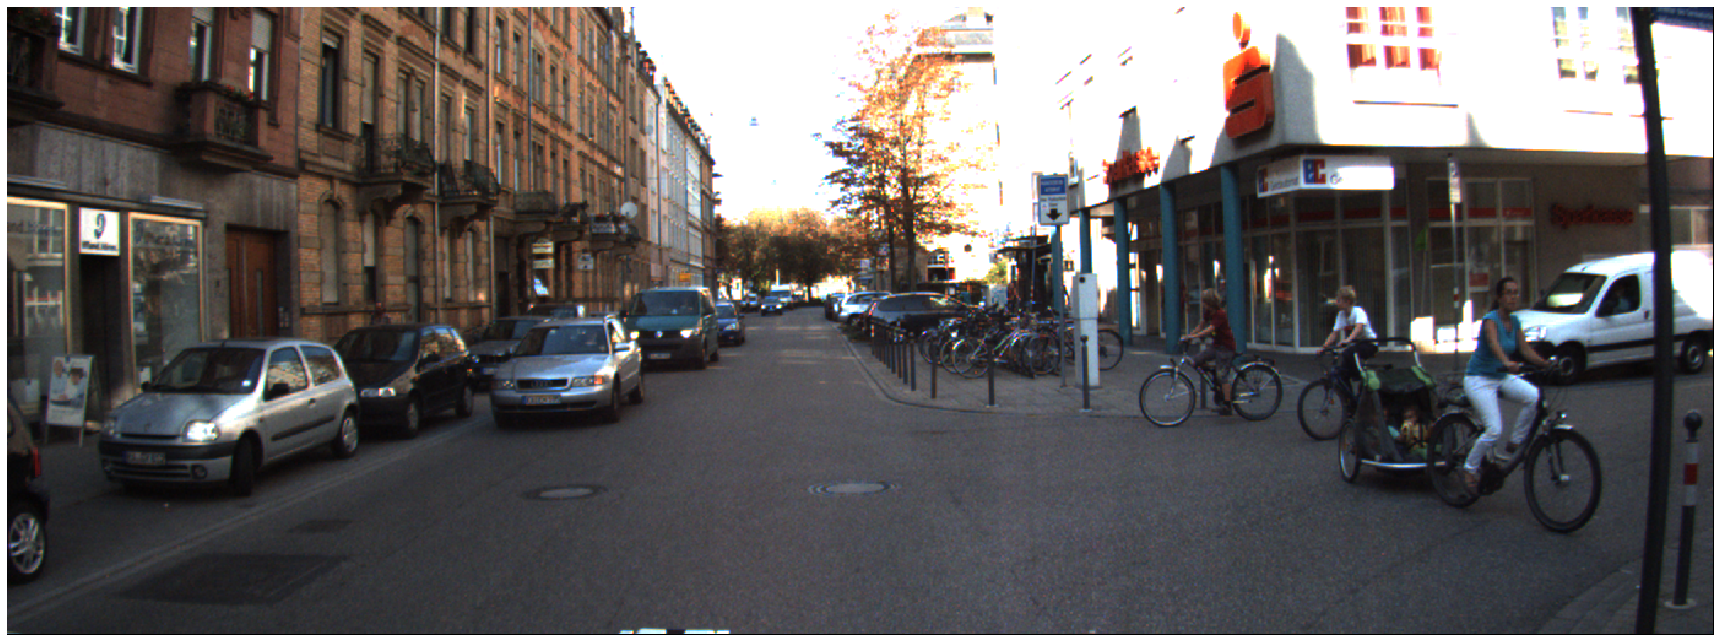

In [23]:
show_image(img_name)

In [24]:
# boxes = get_boxes(net, img_name, target_classes)
with open(img_name, "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
    r = requests.post("http://13.52.225.143:5000/analyze", data=encoded_string) 
    if r.status_code == 200:
        boxes = dict((int(key), np.array(ll, dtype=np.float32)) for key, ll in json.loads(r.content).items())
display(boxes)

{6: array([], dtype=float32),
 7: array([[  55.505333,  255.35178 ,  307.45377 ,  410.11905 ],
        [ 253.27113 ,  250.51884 ,  394.3789  ,  356.98224 ],
        [ 375.4252  ,  243.14316 ,  527.52264 ,  349.4271  ],
        [ 495.61768 ,  220.51071 ,  591.4031  ,  301.5784  ],
        [ 567.09564 ,  234.61484 ,  604.5827  ,  282.74564 ],
        [ 659.87213 ,  228.71011 ,  695.      ,  261.68707 ],
        [ 369.47345 ,  259.89508 ,  434.70575 ,  302.23413 ],
        [1206.719   ,  191.66916 , 1391.      ,  315.3127  ],
        [ 696.      ,  227.46806 ,  788.27386 ,  275.51675 ]],
       dtype=float32),
 15: array([[1179.1675 ,  201.95905, 1270.3802 ,  417.9272 ],
        [1063.2695 ,  216.10773, 1119.0347 ,  340.8363 ],
        [ 957.3976 ,  215.0155 , 1011.5963 ,  319.9276 ]], dtype=float32)}

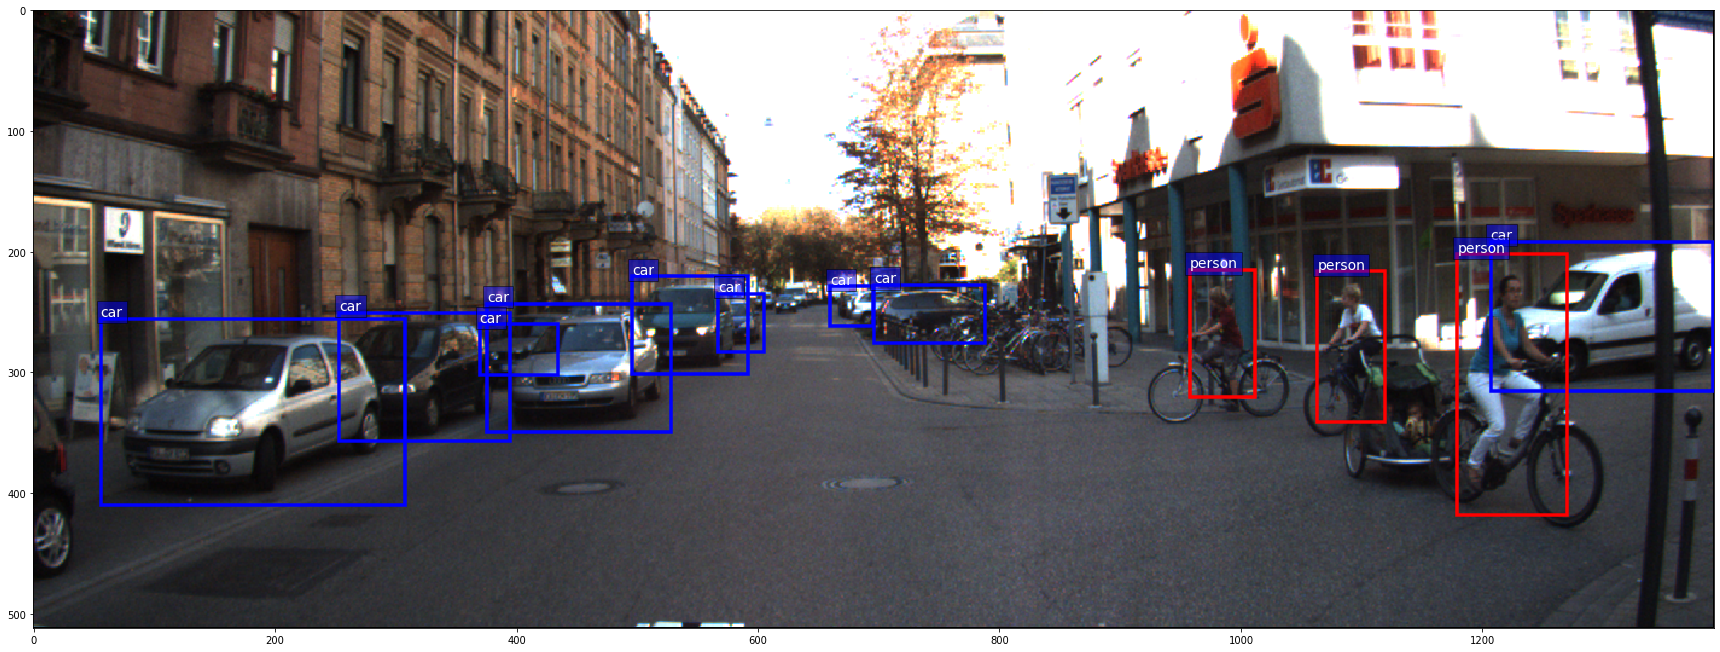

In [25]:
draw_boxes(img_name, boxes)

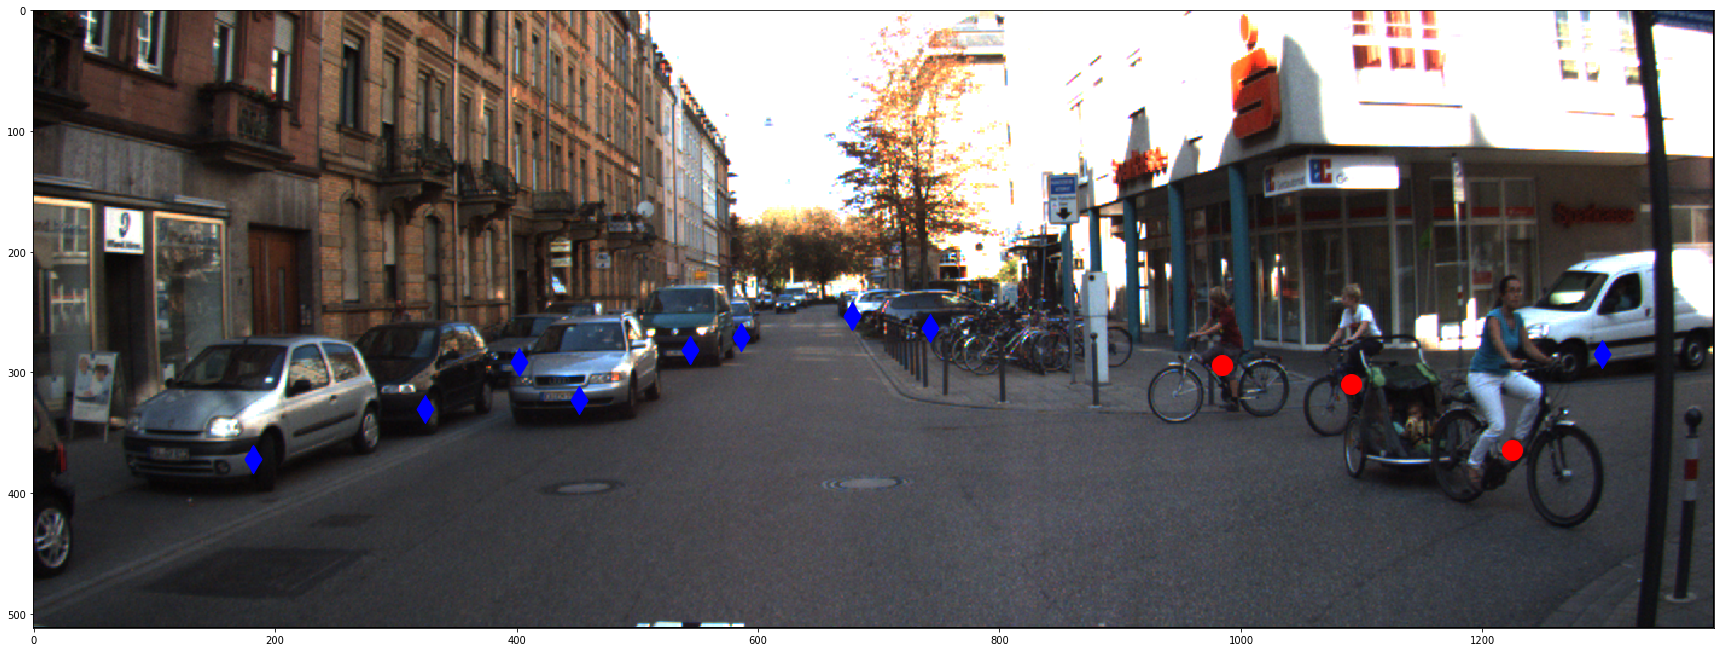

In [28]:
draw_points(img_name, boxes)

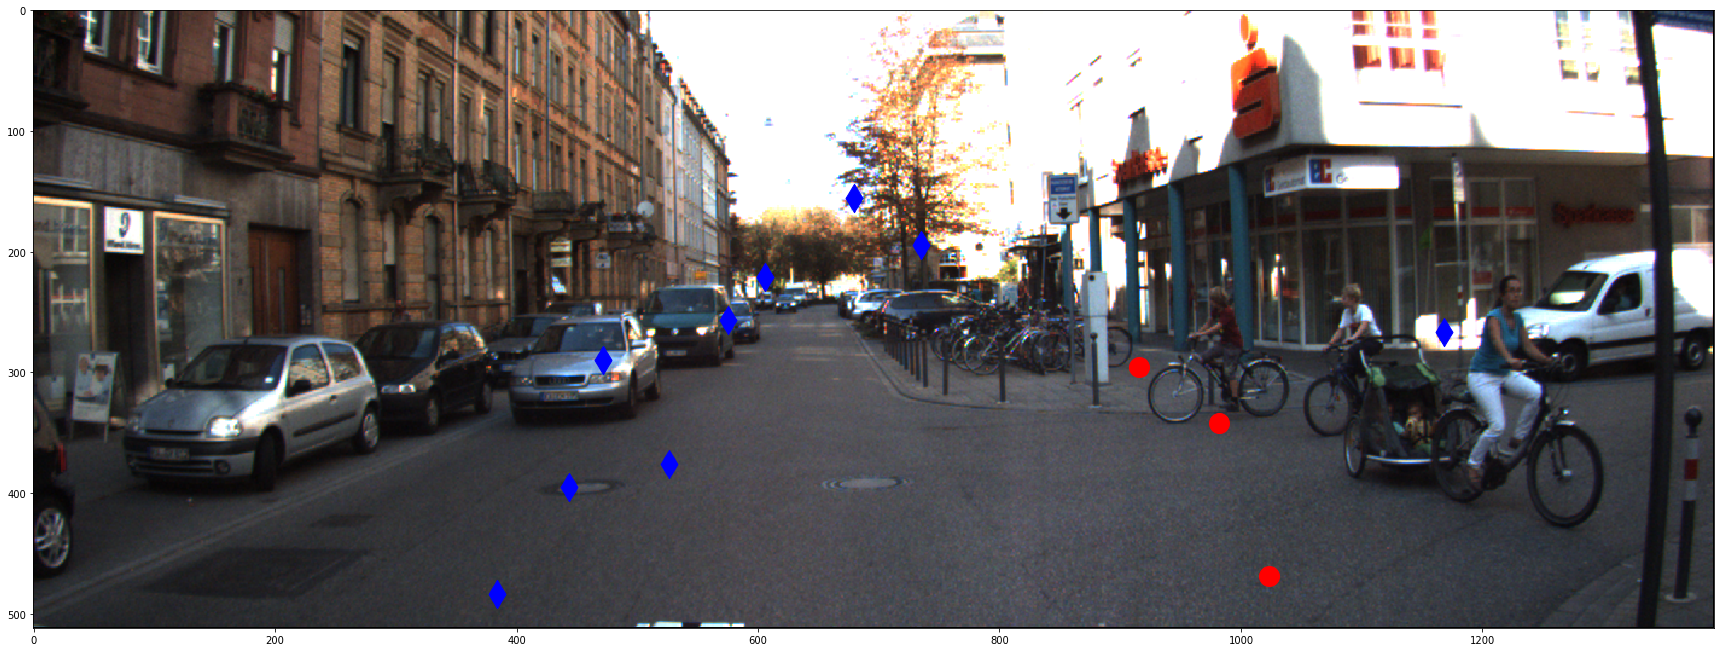

In [31]:
draw_transformed_points(img_name, boxes)

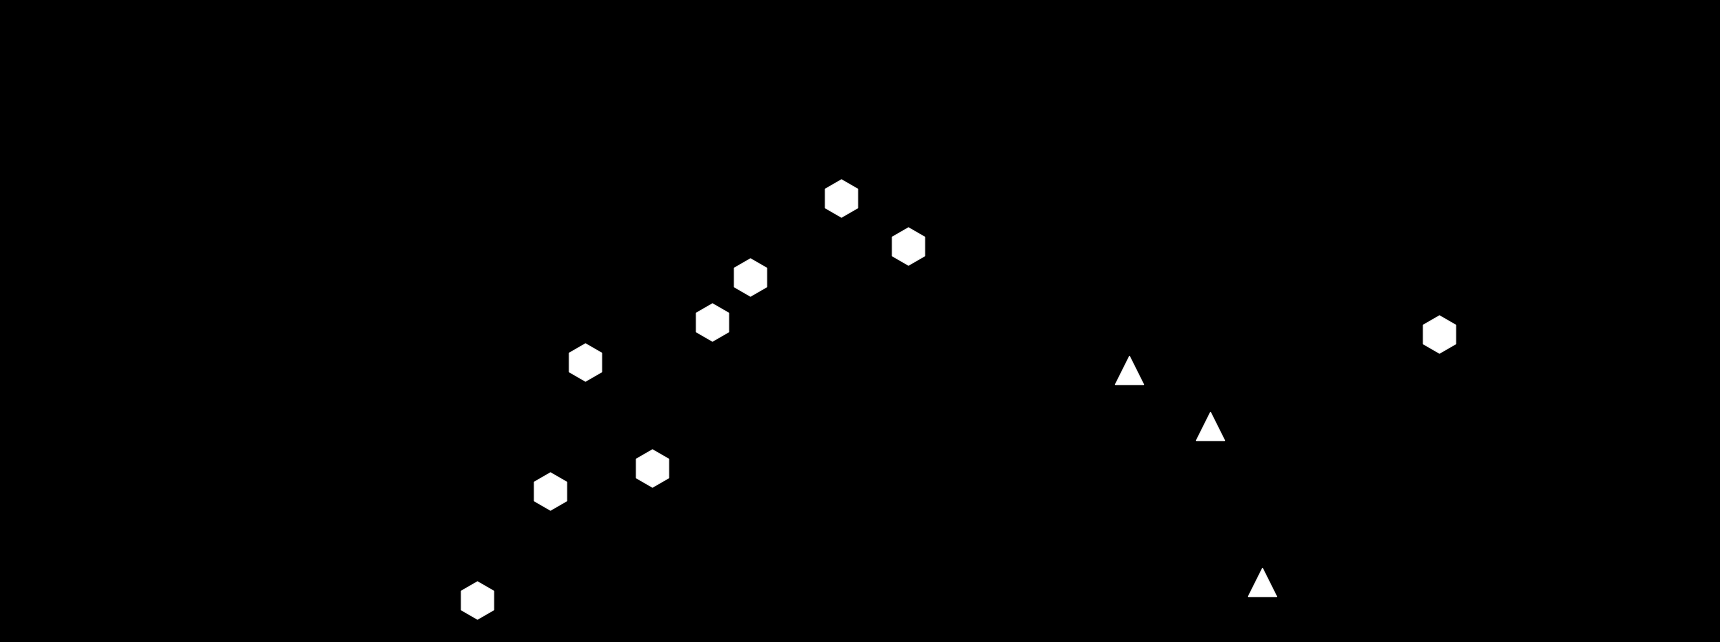

In [32]:
draw_HUD_image(boxes)